In [1]:
import os
import scipy.io.wavfile as spwav
import numpy as np
import pandas as pd

def min_max_avg(ary: np.array) -> tuple:
    """
    Extract minimum, maximum, and compute the average of the array

    Args:
        ary (np.array): input array

    Returns:
        tuple: tuple of (min, max, avg)
    """
    return (np.min(ary), np.max(ary), np.mean(ary))


def create_dict_dataset(path:str, is_eval:bool=False) -> tuple:
    """
    function used to read the dataset. It creates a dictionary in
    the following form:
    id: {label, array, min_max_avg}

    Args:
        path (str): path used to read the dataset
        is_eval (bool, optional): boolean flag to set to True
        if the dataset you want to read is the evaluation one.
        Defaults to False.

    Returns:
        tuple: dataset in dictionary form, list of arrays' shape (num of samples), list of arrays
    """
    samples = os.listdir(path)
    d = dict()
    frequency = spwav.read(path + samples[0])[0]
    lengths = []
    mma_list = [] # min_max_avg list
    arys = []
    for sample in samples:
        if is_eval:
            id = int(sample.split('.')[0])
        else:
            id = int(sample.split('_')[0])
        ary = spwav.read(path + sample)[1]
        time_length = ary.shape
        arys.append(ary)
        lengths.append(time_length)
        mma_list.append(min_max_avg(ary))
        if is_eval:
            d_temp = {'ary': ary,
                    'min_max_avg':min_max_avg(ary),
                    'time': round(time_length[0]/frequency, 2)} # till -4 since it has the .wav extension
        else:
            d_temp = {'label': int(sample.split('_')[1][:-4]),
                    'ary': ary,
                    'min_max_avg':min_max_avg(ary),
                    'time': round(time_length[0]/frequency, 2)} # till -4 since it has the .wav extension
        d[id] = d_temp 
    return d, lengths, arys

def padding(ary: np.array, target_len:int, padding_element:int=0) -> np.array:
    """
    Pad an array with the given length and the given element

    Args:
        ary (np.array): input array to pad
        target_len (int): length to pad the array
        padding_element (int, optional): element used to pad. Defaults to 0.

    Returns:
        np.array: padded array
    """
    return np.pad(ary, (0, target_len), 'constant',  constant_values=padding_element)

def pad_arrays(arys:list, max_length:int, value=0,) -> list:
    """
    Function that padd all the arrays to the given max length

    Args:
        arys (list): list of arrays to pad
        max_length (int): target length of the array
        value (int, optional): value used to pad. Values can be 'mean' or generic values. Defaults to 0.

    Returns:
        list: list of padded arrays
    """
    new_arys = []
    for a in arys:
        width_to_pad = max_length-len(a)
                
        if value == 'mean':
            new_ar = padding(a, width_to_pad, np.mean(a))
        else:
            new_ar = padding(a, width_to_pad, value)
    
        new_arys.append(new_ar)
    return new_arys

## arrivato al punto in cui devo vedere se mettere o meno new_mma_list. 
# Creare funzione per creare il dataframe.

def compute_mma_list(arys:list) -> list:
    """
    Function that will compute min, max, and mean of each array in a given list

    Args:
        arys (list): list of arrays

    Returns:
        list: list of tuples of min, max, and average. 
        One entry for each array in arys
    """
    mma_list = []
    for a in arys:
        mma_list.append(min_max_avg(a))
    return mma_list

def create_df(d:dict, arys:list, avg_threshold=-5) -> pd.DataFrame:
    mma_list = compute_mma_list(arys)
    df = pd.DataFrame.from_dict(d).T
    df.ary = arys
    df.min_max_avg = mma_list
    df.sort_index(axis=0, inplace=True)
    avg = []
    for tup in df.min_max_avg:
        avg.append(tup[-1])
    df['avg'] = avg
    # noise removal, we remove arrays with mean value below -5. 
    # I've seen that even if I pad with 0, the overall mean is strongly below -5,
    # but I know I should do it in a more general way
    mask = df['avg'] > avg_threshold
    return df[mask]

def simple_moving_average(list_of_arys:list) -> np.array:
    list_of_arys = list(list_of_arys)
    ary = np.zeros(shape=(len(list_of_arys)))
    for id in range(len(list_of_arys)):
        num_values = len(list_of_arys[id])
        tot = np.sum(list_of_arys[id])
        ary[id] = tot/num_values
    return ary

def cumulative_moving_average(list_of_arys:list) -> np.array:
    temp = [(np.sum(i), len(i)) for i in list_of_arys]
    mean_variable = 0
    values_cnt = 0
    out_list = []
    
    for i in range(len(temp)):
        sum, l = temp[i]
        if i == 0:
            mean_variable = sum/l
            values_cnt += l
            out_list.append(mean_variable)
        else:
            mean_variable = (sum + values_cnt*mean_variable)/(l + values_cnt)
            values_cnt += l
            out_list.append(mean_variable)


    return np.array(out_list)

def bucket(df:pd.DataFrame, num_buckets:int=100, type_of_feature:str='sma', is_eval:bool=False):
    another_dict = dict()

    for id, array in zip(df.ary.index, df.ary):
        split_ary = np.array_split(array, num_buckets)
        cnt_feature = 0
        features = dict()
        for subary in split_ary:
            features[f'feature_{cnt_feature}'] = subary
            cnt_feature += 1
        another_dict[id] = features
    
    if type_of_feature == 'sma':
        # Simple moving average
        sma_dict = {}
        for key, item in another_dict.items():
            simple_mean = simple_moving_average(item.values())
            sma_dict[key] = {f'feature_{i}':m for i,m in enumerate(simple_mean)}
        bucket_df = pd.DataFrame.from_dict(sma_dict).T
        
    elif type_of_feature == 'cma':
        # Cumulative moving average
        cum_avg_dict = dict()
        for key, item in another_dict.items():
            mean = cumulative_moving_average(item.values())        
            cum_avg_dict[key] = {f'feature_{i}': m for i,m in enumerate(mean)}
        bucket_df = pd.DataFrame.from_dict(cum_avg_dict).T
    if is_eval: 
        return bucket_df    
    
    bucket_df['label'] = df.label
    return bucket_df

# Preprocessing

In [2]:
# train dataset
dev, train_lengths, train_arys = create_dict_dataset('./free_spoken_digit/dev/')
dev_max_length = max(train_lengths)[0]

# eval dataset
eval, eval_lengths, eval_arys = create_dict_dataset('./free_spoken_digit/eval/', is_eval= True)
eval_max_length = max(eval_lengths)[0]

#check the maximum length between train and eval, to have homogeneous padding
if eval_max_length > dev_max_length: 
    max_length = eval_max_length
else:
    max_length = dev_max_length
    
#### train ####
train_new_arys = pad_arrays(train_arys, max_length, 0)
train_df = create_df(dev, train_new_arys, avg_threshold=-5)
bucket_train_df = bucket(train_df, 1000, type_of_feature='sma')

#### eval #####
eval_new_arys = pad_arrays(eval_arys, eval_max_length, 0) # must be coherent with train!
eval_df = create_df(eval, eval_new_arys, avg_threshold=-5)
bucket_eval_df = bucket(eval_df, 1000, type_of_feature='sma', is_eval=True) # again, must be coherent with train



In [3]:
bucket_train_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_991,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999,label
0,6.894737,-7.157895,10.789474,14.210526,22.473684,-38.421053,2.684211,-50.368421,146.421053,-535.368421,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
1,-0.210526,-0.736842,-1.105263,0.578947,-1.473684,-2.789474,2.000000,-0.473684,-1.105263,-0.578947,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,7
2,1.789474,-4.315789,1.842105,-8.578947,0.894737,-5.526316,-2.578947,3.421053,-1.842105,0.315789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
4,0.894737,17.421053,25.578947,-26.105263,-20.157895,-4.631579,-17.578947,1.684211,6.789474,3.789474,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
6,9.473684,-42.947368,65.157895,-21.736842,-38.631579,165.526316,-298.631579,158.421053,83.578947,-193.052632,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [4]:
bucket_eval_df.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_990,feature_991,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999
1,9.736842,-48.631579,50.368421,24.789474,-130.736842,154.052632,-31.157895,-123.105263,150.578947,-2.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,-1.526316,-10.210526,-16.947368,137.947368,-97.210526,16.157895,-28.736842,-7.526316,-10.000000,21.315789,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,6.105263,6.631579,-13.842105,1.368421,14.526316,-7.736842,-24.315789,32.526316,-0.473684,-31.263158,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.421053,-1.421053,2.157895,-3.842105,-0.368421,-1.578947,-1.157895,-4.578947,3.894737,-0.631579,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,9.526316,-6.947368,-15.947368,25.947368,-5.473684,-20.526316,150.157895,79.736842,-262.894737,114.736842,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Classifiers
We will use macro F1 score as metric. The F1 score is:
$$F1_{score} = 2\cdot\frac{Precision\cdot Recall}{Precision + Recall}$$
where
$$Precision = \frac{TP}{TP + FP}$$
$$Recall = \frac{TP}{TP + FN}$$

Worst value of F1 score is 0, while the best one is 1.

In [ ]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

np.random.seed(0) #to make experiments reproducible

X_train, X_test, y_train, y_test = train_test_split(bucket_train_df[bucket_train_df.columns[:-1]], bucket_train_df[bucket_train_df.columns[-1]], test_size=.2)

y_train = y_train.astype('int')
y_test = y_test.astype('int')


In [101]:
clf = DecisionTreeClassifier().fit(X_train, y_train)
preds = clf.predict(X_test)
f1_score(y_test, preds, average='macro')

0.20931129986500788

In [147]:
rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=30).fit(X_train, y_train)
preds = rf.predict(X_test)
f1_score(y_test, preds, average='macro')

0.39850737721475016

In [119]:
knn = KNeighborsClassifier(n_neighbors=7).fit(X_train, y_train)
preds = knn.predict(X_test)
f1_score(y_test, preds, average='macro')

0.15383813941560903

In [127]:
from sklearn.naive_bayes import GaussianNB
from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler().fit(X_train)
#X_train = scaler.transform(X_train)
gnb = GaussianNB().fit(X_train, y_train)
preds = gnb.predict(X_test)
f1_score(y_test, preds, average='macro')

0.1543745991823065

In [137]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVC

svm_clf = make_pipeline(StandardScaler(), NuSVC(degree=1))
svm_clf.fit(X_train, y_train)
preds = svm_clf.predict(X_test)
f1_score(y_test, preds, average='macro')


0.15765029059521102

In [143]:
# Neural Network, MLP
from sklearn.neural_network import MLPClassifier
mlp = MLPClassifier(max_iter=300).fit(X_train, y_train)
preds = mlp.predict(X_test)
f1_score(y_test, preds, average='macro')

0.12737773985155904

---------------

Indeed, results are not satisfactory. We should think to another kind of processing. We should think of frequency domain processing.

In [8]:
dev_samples = os.listdir('./free_spoken_digit/dev/')

In [38]:
from scipy.io import wavfile
from scipy import signal

sample_rate, samples = wavfile.read('./free_spoken_digit/dev/' + dev_samples[10])
frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)


Text(0, 0.5, 'Frequency (Hz)')

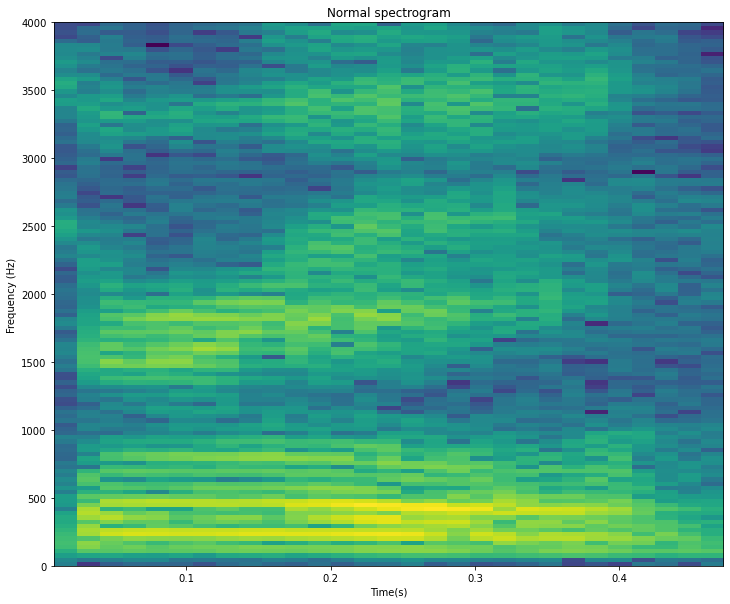

In [73]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,10))
plt.specgram(x = samples, Fs = sample_rate, cmap='viridis') #x = array of samples, Fs = sample rate
plt.title('Normal spectrogram')
plt.xlabel('Time(s)')
plt.ylabel('Frequency (Hz)')

Text(0, 0.5, 'Amplitude')

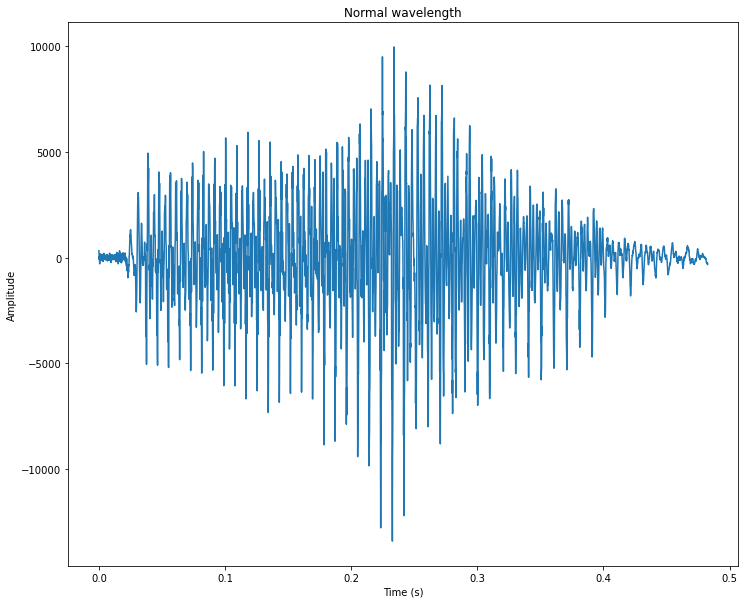

In [47]:
times_axis = np.linspace(0, samples.shape[0]/sample_rate, num=len(samples))
plt.figure(figsize=(12,10))
plt.plot(times_axis, samples)
plt.title('Normal wavelength')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

Let's pad the array

In [80]:
padded_sample = pad_arrays([samples], max_length, 0)[0]

Text(0, 0.5, 'Frequency (Hz)')

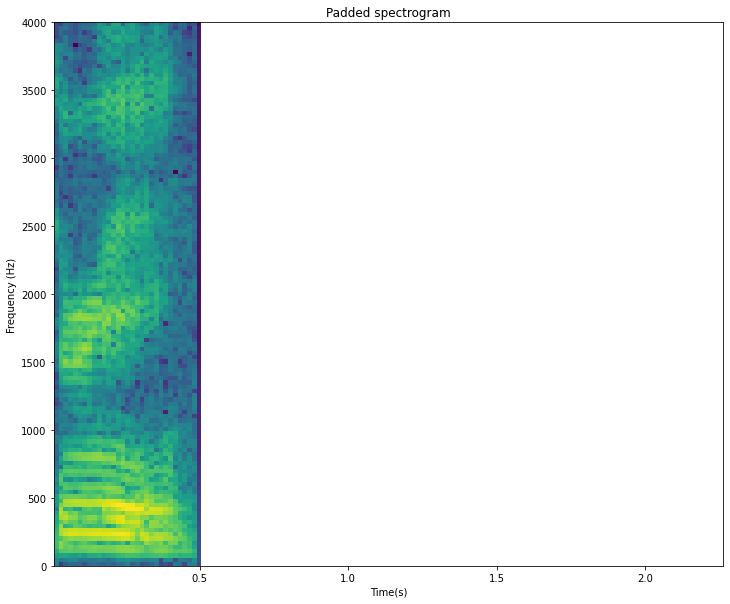

In [82]:
plt.figure(figsize=(12,10))
plt.specgram(x = padded_sample, Fs = sample_rate, cmap='viridis') #x = array of samples, Fs = sample rate
plt.title('Padded spectrogram')
plt.xlabel('Time(s)')
plt.ylabel('Frequency (Hz)')

Text(0, 0.5, 'Amplitude')

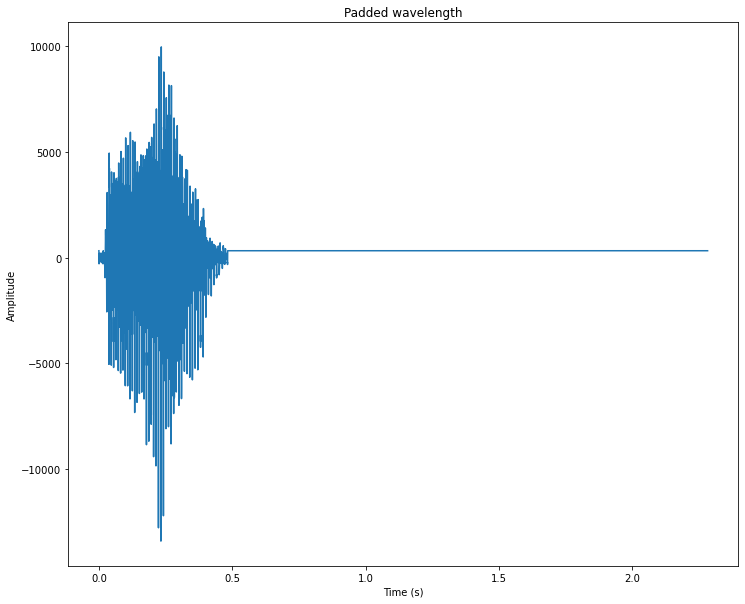

In [64]:
# plot wavelength
times_axis = np.linspace(0, padded_sample.shape[0]/sample_rate, num=max_length)
plt.figure(figsize=(12,10))
plt.plot(times_axis, padded_sample)
plt.title('Padded wavelength')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

Do I really need to pad? If I want to divide into N x M blocks the spectrogram, I can do it in the same manner for each array. What I mean is, I can give as input how many N and how many M I want, and then divide the array as wanted. In such a manner I shall have NxM blocks for each sample. From them, I can extract mean and std deviation.

Dimension of frequencies don't change over samples. Thus we have a fixed dimension. What changes is the dimension of times.

In [244]:
def divide_matrix(ary:np.array, num_columns:int, num_rows:int):    
    
    if (num_columns > ary.shape[1] or num_rows > ary.shape[0]):
        return 'Error, the requested number of columns or rows exceed dimensions!'
    
    first = np.array_split(ary, num_rows, axis=0) # num rows
    second = []
    for array in first:
        second.append(np.array_split(array, num_columns, axis=1)) # num columns
    flattened_list = flatten(second)
    return flattened_list

def flatten(l:list):
    flattened_list = []
    for item in l:
        for i in item:
            flattened_list.append(i)
    return flattened_list
    
def compute_feature(list_of_arrays:list) -> dict:
    d = dict()
    for id in range(len(list_of_arrays)):
        d[f'mean_feature_{id}'] = np.mean(list_of_arrays[id])
        d[f'std_feature_{id}'] = np.std(list_of_arrays[id])
    return d

def create_dict_dataset(path:str, is_eval:bool=False) -> dict:
    """
    function used to read the dataset. It creates a dictionary in
    the following form:
    id: {label, frequencies, times, spectrogram}.
    If is_eval == True, no label.

    Args:
        path (str): path used to read the dataset
        is_eval (bool, optional): boolean flag to set to True
        if the dataset you want to read is the evaluation one.
        Defaults to False.

    Returns:
        dict: dataset in dictionary form
    """
    all_samples = os.listdir(path)
    d = dict()
    for sample in all_samples:
        if is_eval:
            id = int(sample.split('.')[0])
        else:
            id = int(sample.split('_')[0])
        sample_rate, samples = spwav.read(path + sample)
        frequencies, times, spectrogram = signal.spectrogram(samples, sample_rate)
        if is_eval:
            d_temp = {'frequencies': frequencies,
                      'times': times,
                      'spectrogram': spectrogram} 
        else:
            d_temp = {'label': int(sample.split('_')[1][:-4]), # till -4 since it has the .wav extension
                    'frequencies': frequencies,
                      'times': times,
                      'spectrogram': spectrogram} 
        d[id] = d_temp 
    return d

In [272]:
d = create_dict_dataset('./free_spoken_digit/dev/')
n = 5 # num rows and num columns
new_d = {}
for id, item in d.items():
    try:
        temp_d = compute_feature(flatten(divide_matrix(item['spectrogram'], num_rows=n, num_columns=n)))
        temp_d['label'] = item['label']
        new_d[id] = temp_d
    except:
        continue

In [265]:
len(new_d) #ne abbiamo persi 2 in battaglia

1498

In [256]:
features = dict()
for key in new_d.keys():
    try:
        features[key] = compute_feature(new_d[key][1])
    except:
        continue

1418
330


problemi con 1418 e 330, hanno come time solo 4 e nella funzione restituisco un errore. Faccio continue, ma ne perderò 2. Non è da escludere che incrementando ne perda altri. Bisogna correggere. Padding? Togliere l'errore dalla funzione e via?

Capiamo

In [262]:
d[1418]['spectrogram'].shape

(129, 4)

In [269]:
df = pd.DataFrame.from_dict(new_d).T
df.sort_index(inplace=True)
#df.rename(columns={0:'label', 1:'divided_ary'}, inplace=True)

In [270]:
df.head()

,mean_feature_0,std_feature_0,mean_feature_1,std_feature_1,mean_feature_2,std_feature_2,mean_feature_3,std_feature_3,mean_feature_4,std_feature_4,...,std_feature_640,mean_feature_641,std_feature_641,mean_feature_642,std_feature_642,mean_feature_643,std_feature_643,mean_feature_644,std_feature_644,label
0,8.056207,10.325981,16.511713,4.751960,36.918652,22.398470,87.634644,37.356968,140.528915,65.092728,...,0.001405,0.003404,0.000699,0.004053,0.000733,0.008566,0.007249,0.000562,0.000502,4.0
1,1.262534,1.131343,5.050905,7.107840,14.990707,21.143711,35.031445,49.321140,263.943817,372.094269,...,0.003969,0.008911,0.007955,0.004264,0.000059,0.001590,0.001288,0.002384,0.002336,7.0
2,20.923159,19.235100,1.144893,1.014744,8.378154,6.052547,35.554825,26.420006,284.330292,310.303436,...,0.012286,0.004504,0.002492,0.003594,0.000555,0.003530,0.002900,0.001397,0.001390,5.0
3,0.321685,0.363578,2.396488,2.231541,1.757551,1.440403,5.742432,4.398920,5.791383,4.123041,...,9.673529,4.896389,2.438909,14.379004,9.166743,11.915939,5.297869,3.405663,3.252888,2.0
4,0.318653,0.312621,0.322919,0.181024,0.319849,0.105676,0.792899,0.633740,1.859853,0.665934,...,0.000000,0.000649,0.000000,0.002230,0.000000,0.004784,0.000000,0.002311,0.000000,3.0


In [271]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

np.random.seed(0) #to make experiments reproducible

X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=.2)

y_train = y_train.astype('int')
y_test = y_test.astype('int')

rf = RandomForestClassifier(n_estimators=100, max_features='sqrt', max_depth=30).fit(X_train, y_train)
preds = rf.predict(X_test)
f1_score(y_test, preds, average='macro')

0.9477180985540707

LET'S GOOOOOOOOOO

Let's find best parameters. We start with n (number of rows and number of columns)

In [280]:
def start(path:str, n:int) -> pd.DataFrame:
    """Generate the dictionary of the dataset.
    The dictionary contains features and label

    Args:
        path (str): path to dataset
        n (int): hyperparameter used as number of rows and number of columns

    Returns:
        pd.DataFrame: dataframe of the dataset
    """
    d = create_dict_dataset(path)
    new_d = {}
    for id, item in d.items():
        try:
            temp_d = compute_feature(flatten(divide_matrix(item['spectrogram'], num_rows=n, num_columns=n)))
            temp_d['label'] = item['label']
            new_d[id] = temp_d
        except:
            continue
    df = pd.DataFrame.from_dict(new_d).T
    df.sort_index(inplace=True)
    return df

In [278]:
list(range(1,40,2))

[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]

In [297]:
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import f1_score

path = './free_spoken_digit/dev/'
n_s = list(range(1,15,2)) # used n, 2 is the step
f1_scores_rf = []
f1_scores_svc = []

for n in n_s:
    df = start(path, n)
    np.random.seed(0) #to make experiments reproducible
    try:
        X_train, X_test, y_train, y_test = train_test_split(df[df.columns[:-1]], df[df.columns[-1]], test_size=.2)

        y_train = y_train.astype('int')
        y_test = y_test.astype('int')
        rf = RandomForestClassifier().fit(X_train, y_train)
        svc = make_pipeline(StandardScaler(), SVC()).fit(X_train, y_train)

        preds_rf = rf.predict(X_test)
        preds_svc = svc.predict(X_test)
        score_rf = f1_score(y_test, preds_rf, average='macro')
        score_svc = f1_score(y_test, preds_svc, average='macro')
        f1_scores_rf.append((n, score_rf))
        f1_scores_svc.append((n, score_svc))
    except:
        f1_scores_rf.append((n, np.NaN))        
        f1_scores_svc.append((n, np.NaN))        
    continue


Text(0, 0.5, 'F1 score')

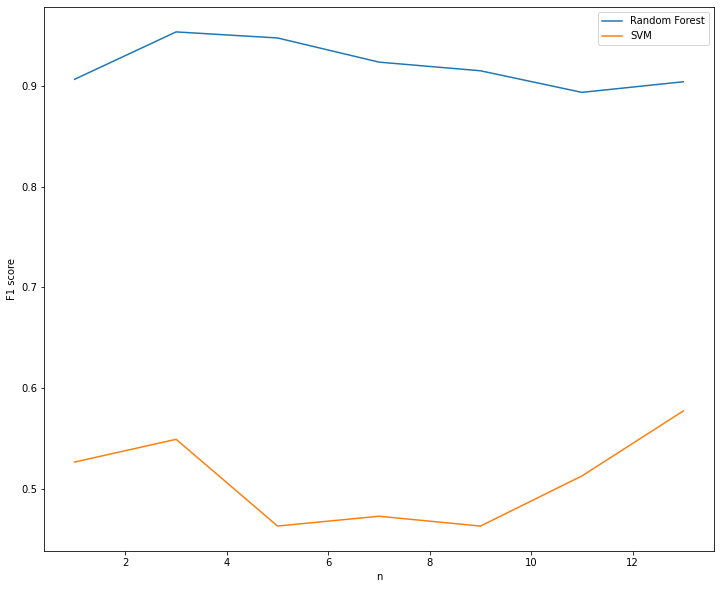

In [299]:
plt.figure(figsize=(12,10))
plt.plot([i[0] for i in f1_scores_rf], [i[1] for i in f1_scores_rf], label='Random Forest')
plt.plot([i[0] for i in f1_scores_svc], [i[1] for i in f1_scores_svc], label='SVM')
plt.legend()
plt.xlabel('n')
plt.ylabel('F1 score')

In [292]:
f1_scores = [i[1] for i in f1_scores]

[(1, 0.9066818285156348),
 (3, 0.953733470334916),
 (5, 0.9477180985540707),
 (7, 0.9237246358614198),
 (9, 0.9151374366910139),
 (11, 0.8936865978192883),
 (13, 0.9042198370105347)]